## Steps

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

**Step 1. Load the houseprices data from Thinkful's database.**

In [1]:
# Load the houseprices data from Thinkful's database.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'  
postgres_pw = '7*.8G9QH21'  
postgres_host = '142.93.121.174'  
postgres_port = '5432'  
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

hp_df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

hp_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


**Step 2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.**

The features were selected by this analysis. Refer to this link https://github.com/feelopk/Thinkful/blob/master/M19.3_Meeting%20the%20assumptions%20of%20linear%20regression_Assignment%202%20(House%20prices).ipynb

In [2]:
hp_sel = hp_df[['saleprice', 'lotfrontage', 'lotarea', 'masvnrarea', 'bsmtfinsf1', 
                'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'grlivarea', 'garagearea']]
hp_sel.replace(0, 1, inplace=True)
hp_sel.fillna(1, inplace=True)
hp_sellog = np.log(hp_sel)
hp_sellog_picked = hp_sellog[['saleprice', 'firstflrsf', 'grlivarea']]

**Step 3. Now, split your data into train and test sets where 20% of the data resides in the test set.**

In [3]:
X = hp_sellog_picked[['firstflrsf', 'grlivarea']]
Y = hp_sellog_picked['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

The number of observations in the training set is 1168
The number of observations in the test set is 292


**Step 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!**

1. Let's start with OLS regression.

In [4]:
from sklearn import linear_model
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)

lrm_y_train = lrm.predict(X_train)
lrm_y_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, lrm_y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, lrm_y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, lrm_y_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - lrm_y_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.5830986251228254 

-----Test set statistics-----
R-squared of the model in the test set is: 0.6336389874815189
Mean absolute error of the prediction is: 0.19571141237787565
Mean squared error of the prediction is: 0.06708278197141096
Root mean squared error of the prediction is: 0.25900344007640314
Mean absolute percentage error of the prediction is: 1.6423068988146043


2. This time, I will do Ridge Regression with built in cross-validation method.

In [5]:
alphas = [np.power(10.0, p) for p in np.arange(-10, 40, 1)]

rgm_cv = linear_model.RidgeCV(alphas=alphas, cv=5)
rgm_cv.fit(X_train, y_train)

rgm_y_train = rgm_cv.predict(X_train)
rgm_y_test = rgm_cv.predict(X_test)

print("Best alpha value is: {}".format(rgm_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(rgm_cv.score(X_train, y_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(rgm_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, rgm_y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, rgm_y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, rgm_y_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - rgm_y_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in the training set is: 0.5830787509561941 

-----Test set statistics-----
R-squared of the model in the test set is: 0.6331752844249631
Mean absolute error of the prediction is: 0.19572859989654126
Mean squared error of the prediction is: 0.06716768863445514
Root mean squared error of the prediction is: 0.2591672985437305
Mean absolute percentage error of the prediction is: 1.6423620289718905


3. This time, I will do Lasso Regression with built in cross-validation method.

In [6]:
lass_cv = linear_model.LassoCV(alphas=alphas, cv=5)
lass_cv.fit(X_train, y_train)

lass_y_train = lass_cv.predict(X_train)
lass_y_test = lass_cv.predict(X_test)

print("Best alpha value is: {}".format(lass_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(lass_cv.score(X_train, y_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lass_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, lass_y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, lass_y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, lass_y_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - lass_y_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in the training set is: 0.5830986178623121 

-----Test set statistics-----
R-squared of the model in the test set is: 0.6336281381775515
Mean absolute error of the prediction is: 0.19571225586548768
Mean squared error of the prediction is: 0.06708476854058106
Root mean squared error of the prediction is: 0.25900727507269183
Mean absolute percentage error of the prediction is: 1.6423122948800752


4. This time, I will do ElasticNet Regression with built in cross-validation method.

In [7]:
elanet_cv = linear_model.ElasticNetCV(alphas=alphas, cv=5)
elanet_cv.fit(X_train, y_train)

elanet_y_train = elanet_cv.predict(X_train)
elanet_y_test = elanet_cv.predict(X_test)

print("Best alpha value is: {}".format(elanet_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(elanet_cv.score(X_train, y_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(elanet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, elanet_y_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, elanet_y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, elanet_y_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - elanet_y_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in the training set is: 0.5830981507304196 

-----Test set statistics-----
R-squared of the model in the test set is: 0.6335540250491034
Mean absolute error of the prediction is: 0.1957172179351988
Mean squared error of the prediction is: 0.0670983390752914
Root mean squared error of the prediction is: 0.25903347095557244
Mean absolute percentage error of the prediction is: 1.642341766621318


**Step 5. Evaluate your best model on the test set.**

In [8]:
# Let's make table to look around at a glance. 

OLS = [0, 0.5830986251228254, 0.6336389874815189, 0.19571141237787565, 0.06708278197141096, 0.25900344007640314, 1.6423068988146043]
Ridge = [1.0, 0.5830787509561941 , 0.6331752844249631, 0.19572859989654126, 0.06716768863445514, 0.2591672985437305, 1.6423620289718905]
Lasso = [1e-05, 0.5830986178623121 , 0.6336281381775515, 0.19571225586548768, 0.06708476854058106, 0.25900727507269183, 1.6423122948800752]
ElasticNet = [0.0001, 0.5830981507304196, 0.6335540250491034, 0.1957172179351988, 0.0670983390752914, 0.25903347095557244, 1.642341766621318]

data = [OLS, Ridge, Lasso, ElasticNet]
index_name = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
col_name = ['Best Alpha', 'R-square (Training)', 'R-square (Test)', 'MAE', 'MSE', 'RMSE', 'MAPE']
table = pd.DataFrame(data, index=index_name, columns=col_name)
table

,Best Alpha,R-square (Training),R-square (Test),MAE,MSE,RMSE,MAPE
OLS,0.00000,0.583099,0.633639,0.195711,0.067083,0.259003,1.642307
Ridge,1.00000,0.583079,0.633175,0.195729,0.067168,0.259167,1.642362
Lasso,0.00001,0.583099,0.633628,0.195712,0.067085,0.259007,1.642312
ElasticNet,0.00010,0.583098,0.633554,0.195717,0.067098,0.259033,1.642342


In [9]:
table.describe()

,Best Alpha,R-square (Training),R-square (Test),MAE,MSE,RMSE,MAPE
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.250028,0.583094,0.633499,0.195717,0.067108,0.259053,1.642331
std,0.499982,0.000010,0.000219,0.000008,0.000040,0.000077,0.000026
min,0.000000,0.583079,0.633175,0.195711,0.067083,0.259003,1.642307
25%,0.000008,0.583093,0.633459,0.195712,0.067084,0.259006,1.642311
50%,0.000055,0.583098,0.633591,0.195715,0.067092,0.259020,1.642327
75%,0.250075,0.583099,0.633631,0.195720,0.067116,0.259067,1.642347
max,1.000000,0.583099,0.633639,0.195729,0.067168,0.259167,1.642362


When you look into the data table, the goodness model would have the largest R-squared value of Test set. And the rest values must be smaller than any others.  
**Then, the OLS model is the best model for this data set which is well presenting the outcome.**

**Step 6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.**

Okay, interest for buying a house, we uaually call it mortage seems like have a great impact on the sales price as you mentioned.  That's a good point.  
So, I want to look into the influence of mortage rate to sale price.

First of all, how many years of mortage rate should I get for the analysis?  
Let's figure it out step by step.

In [10]:
hp_df.yrsold.describe()

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: yrsold, dtype: float64

Okay, I need to find out the mortage rate from 2006 to 2010. It's not big thing, just 5 years data.  

And fortunately I got the data in a second by googling. Here is the [link](https://www.valuepenguin.com/mortgages/historical-mortgage-rates#nogo). I just want to narrow the case into30-Year Fixed-Rate Mortgages for more common analysis.  
Let's bring the data into python.

In [32]:
interest = {'Years' : [2006, 2007, 2008, 2009, 2010], 'Interest Rate':[6.41, 6.34, 6.03, 5.04, 4.69]}
pd.DataFrame(interest)

,Years,Interest Rate
0,2006,6.41
1,2007,6.34
2,2008,6.03
3,2009,5.04
4,2010,4.69


Now, let's duplicate the 'yrsold' column and replace the years to interest rate.

In [39]:
hp_df['interest_rate'] = hp_df['yrsold'].copy()
interest = [{2006:6.41, 2007:6.34, 2008:6.03, 2009:5.04}, {2010:4.69}]
for a in interest:
    hp_df['interest_rate'].replace(a, inplace=True)
print('The sum of the null values in interest rate column is :', hp_df['interest_rate'].isnull().sum())
hp_df['interest_rate'].head(10)

The sum of the null values in interest rate column is : 0


0    6.03
1    6.34
2    6.03
3    6.41
4    6.03
5    5.04
6    6.34
7    5.04
8    6.03
9    6.03
Name: interest_rate, dtype: float64

Hume, It looks good.
Now, check the data condition with some graph and if needed, let's do data cleaning.

This is Univariate Analysis of Interest Price variable


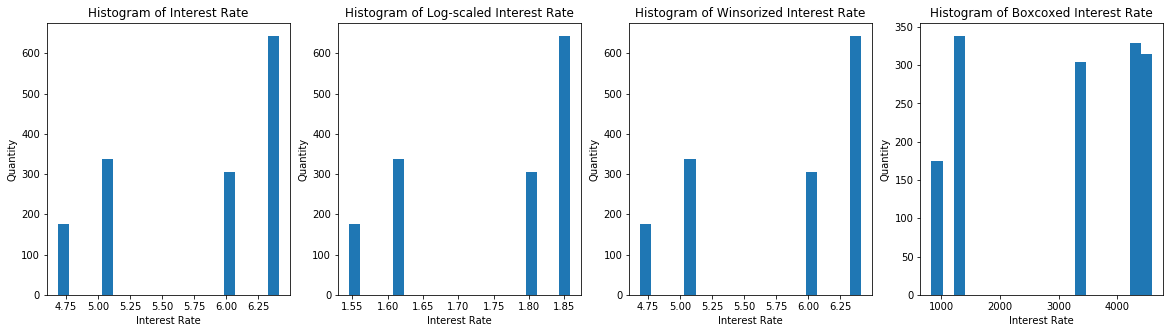

In [86]:
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize

x = hp_df['saleprice']
y = hp_df['interest_rate']
plt.figure(figsize=(20,5))

print('This is Univariate Analysis of Interest Price variable')
plt.subplot(1, 4, 1)
plt.hist(y, bins=20)
plt.title('Histogram of Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Quantity')

plt.subplot(1, 4, 2)
plt.hist(np.log(y), bins=20)
plt.title('Histogram of Log-scaled Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Quantity')

plt.subplot(1, 4, 3)
plt.hist(winsorize(y), bins=20)
plt.title('Histogram of Winsorized Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Quantity')

plt.subplot(1, 4, 4)
plt.hist(boxcox(y)[0], bins=20)
plt.title('Histogram of Boxcoxed Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Quantity')

plt.show()

This is Bivariate Analysis between Several transformation of Interest Price variable and Log-scaled Sale Price


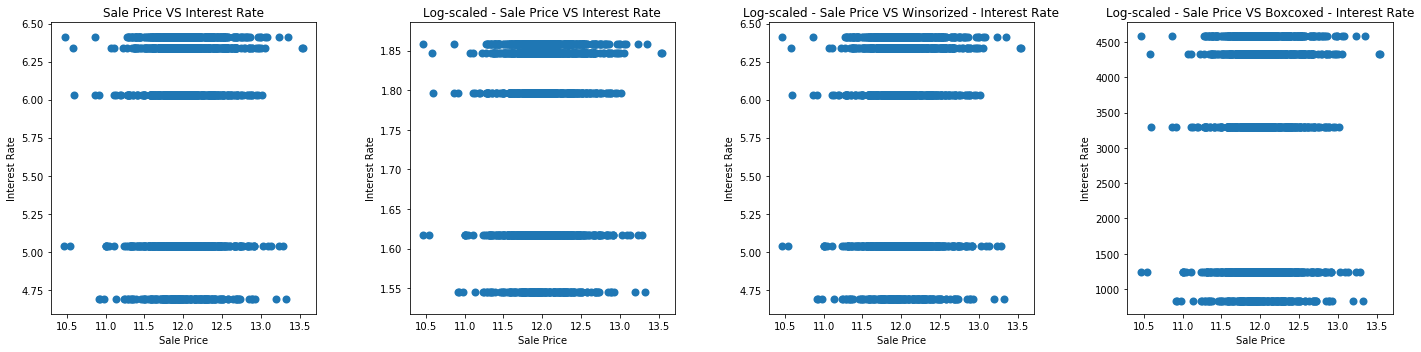

In [106]:
print('This is Bivariate Analysis between Several transformation of Interest Price variable and Log-scaled Sale Price')

plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.scatter(np.log(x), y, linewidths=2)
plt.title('Sale Price VS Interest Rate')
plt.xlabel('Sale Price')
plt.ylabel('Interest Rate')

plt.subplot(1, 4, 2)
plt.scatter(np.log(x), np.log(y), linewidths=2)
plt.title('Log-scaled - Sale Price VS Interest Rate')
plt.xlabel('Sale Price')
plt.ylabel('Interest Rate')

plt.subplot(1, 4, 3)
plt.scatter(np.log(x), winsorize(y), linewidths=2)
plt.title('Log-scaled - Sale Price VS Winsorized - Interest Rate')
plt.xlabel('Sale Price')
plt.ylabel('Interest Rate')

plt.subplot(1, 4, 4)
plt.scatter(np.log(x), boxcox(y)[0], linewidths=2)
plt.title('Log-scaled - Sale Price VS Boxcoxed - Interest Rate')
plt.xlabel('Sale Price')
plt.ylabel('Interest Rate')

plt.tight_layout()
plt.show()

Let's figure out the correlation between Sale Price and Interest Rate.

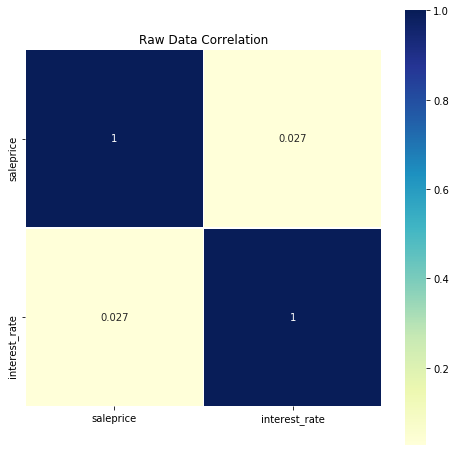

In [105]:
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sale_interest = hp_df[['saleprice', 'interest_rate']]
sale_interest_corr = hp_df[['saleprice', 'interest_rate']].corr()

plt.figure(figsize=(8,8))
sns.heatmap(sale_interest_corr, square=True, linewidths=0.5, annot=True, cmap='YlGnBu')
plt.title('Raw Data Correlation')
plt.show()

With the correlation graph, Interest Rate variable seems that it could not be good feature. Because they are very unrelated.  
Also, changing the variable with several method is not meaningful to make it more valueable.  

However, let's put it(raw data) in the already collected features and find out another way to make it valuable.

In [122]:
hp_sellog_picked.insert(3, 'interest_rate', hp_df['interest_rate'])

In [124]:
hp_sellog_picked_interest = hp_sellog_picked

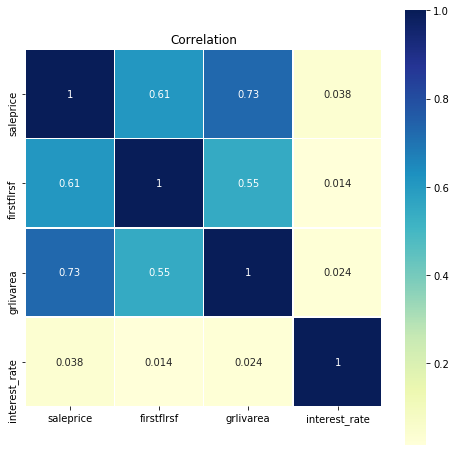

In [126]:
hp_sellog_picked_interest_corr = hp_sellog_picked_interest.corr()

plt.figure(figsize=(8,8))
sns.heatmap(hp_sellog_picked_interest_corr, square=True, linewidths=0.5, annot=True, cmap='YlGnBu')
plt.title('Correlation')
plt.show()

There goes my last hope about Interest rate variable.  
I really eager that the Interest rate variable shows me some kinds of magic like a surprise present with other features.  
However, nothing special.  

As we know, with lots of noise data could make the model overfitted. So, in this part let's figure out how this unrelated variable spoils the our goodness model what we make above.

Okay, from now on, let's make models as I already did on the top.

In [127]:
X1 = hp_sellog_picked_interest[['firstflrsf', 'grlivarea', 'interest_rate']]
Y1 = hp_sellog_picked_interest['saleprice']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

print("The number of observations in the training set is {}".format(X1_train.shape[0]))
print("The number of observations in the test set is {}".format(X1_test.shape[0]))

The number of observations in the training set is 1168
The number of observations in the test set is 292


1. Let's start with OLS regression.

In [128]:
lrm1 = linear_model.LinearRegression()
lrm1.fit(X1_train, y1_train)

lrm1_y1_train = lrm1.predict(X1_train)
lrm1_y1_test = lrm1.predict(X1_test)

print("R-squared of the model in the training set is: {}".format(lrm1.score(X1_train, y1_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm1.score(X1_test, y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, lrm1_y1_test)))
print("Mean squared error of the prediction is: {}".format(mse(y1_test, lrm1_y1_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y1_test, lrm1_y1_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - lrm1_y1_test) / y1_test)) * 100))

R-squared of the model in the training set is: 0.5832146675886636 

-----Test set statistics-----
R-squared of the model in the test set is: 0.634562074628402
Mean absolute error of the prediction is: 0.19539245600399038
Mean squared error of the prediction is: 0.0669137594725668
Root mean squared error of the prediction is: 0.2586769403572085
Mean absolute percentage error of the prediction is: 1.6396633142001356


2. This time, I will do Ridge Regression with built in cross-validation method.

In [130]:
rgm1_cv = linear_model.RidgeCV(alphas=alphas, cv=5)
rgm1_cv.fit(X1_train, y1_train)

rgm1_y1_train = rgm1_cv.predict(X1_train)
rgm1_y1_test = rgm1_cv.predict(X1_test)

print("Best alpha value is: {}".format(rgm1_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(rgm1_cv.score(X1_train, y1_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(rgm1_cv.score(X1_test, y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, rgm1_y1_test)))
print("Mean squared error of the prediction is: {}".format(mse(y1_test, rgm1_y1_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y1_test, rgm1_y1_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - rgm1_y1_test) / y1_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in the training set is: 0.5831948002991127 

-----Test set statistics-----
R-squared of the model in the test set is: 0.6341056990663082
Mean absolute error of the prediction is: 0.1954173731834066
Mean squared error of the prediction is: 0.06699732442976175
Root mean squared error of the prediction is: 0.2588384137444861
Mean absolute percentage error of the prediction is: 1.6397860097906276


3. This time, I will do Lasso Regression with built in cross-validation method.

In [131]:
lass1_cv = linear_model.LassoCV(alphas=alphas, cv=5)
lass1_cv.fit(X1_train, y1_train)

lass1_y1_train = lass1_cv.predict(X1_train)
lass1_y1_test = lass1_cv.predict(X1_test)

print("Best alpha value is: {}".format(lass1_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(lass1_cv.score(X1_train, y1_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lass1_cv.score(X1_test, y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, lass1_y1_test)))
print("Mean squared error of the prediction is: {}".format(mse(y1_test, lass1_y1_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y1_test, lass1_y1_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - lass1_y1_test) / y1_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in the training set is: 0.5831190394832557 

-----Test set statistics-----
R-squared of the model in the test set is: 0.6330020505341318
Mean absolute error of the prediction is: 0.19564904160027383
Mean squared error of the prediction is: 0.0671994087436687
Root mean squared error of the prediction is: 0.25922848752339833
Mean absolute percentage error of the prediction is: 1.641637047311248


4. This time, I will do ElasticNet Regression with built in cross-validation method.

In [132]:
elanet1_cv = linear_model.ElasticNetCV(alphas=alphas, cv=5)
elanet1_cv.fit(X1_train, y1_train)

elanet1_y1_train = elanet1_cv.predict(X1_train)
elanet1_y1_test = elanet1_cv.predict(X1_test)

print("Best alpha value is: {}".format(elanet1_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(elanet1_cv.score(X1_train, y1_train)), '\n')
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(elanet1_cv.score(X1_test, y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y1_test, elanet1_y1_test)))
print("Mean squared error of the prediction is: {}".format(mse(y1_test, elanet1_y1_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y1_test, elanet1_y1_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y1_test - elanet1_y1_test) / y1_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in the training set is: 0.5831636539976289 

-----Test set statistics-----
R-squared of the model in the test set is: 0.6335245777494662
Mean absolute error of the prediction is: 0.19553501092583175
Mean squared error of the prediction is: 0.06710373104308741
Root mean squared error of the prediction is: 0.2590438786057053
Mean absolute percentage error of the prediction is: 1.6407194813405215


In [147]:
# Let's make table to look around at a glance. 

OLS = [0, 0.5830986251228254, 0.6336389874815189, 0.19571141237787565, 0.06708278197141096, 0.25900344007640314, 1.6423068988146043]
Ridge = [1.0, 0.5830787509561941 , 0.6331752844249631, 0.19572859989654126, 0.06716768863445514, 0.2591672985437305, 1.6423620289718905]
Lasso = [1e-05, 0.5830986178623121 , 0.6336281381775515, 0.19571225586548768, 0.06708476854058106, 0.25900727507269183, 1.6423122948800752]
ElasticNet = [0.0001, 0.5830981507304196, 0.6335540250491034, 0.1957172179351988, 0.0670983390752914, 0.25903347095557244, 1.642341766621318]

OLS1 = [0, 0.5832146675886636, 0.634562074628402, 0.19539245600399038, 0.0669137594725668, 0.2586769403572085, 1.6396633142001356]
Ridge1 = [1.0, 0.5831948002991127, 0.6341056990663082, 0.1954173731834066, 0.06699732442976175, 0.2588384137444861, 1.6397860097906276]
Lasso1 = [0.001, 0.5831190394832557, 0.6330020505341318, 0.19564904160027383, 0.0671994087436687, 0.25922848752339833, 1.641637047311248]
ElasticNet1 = [0.001, 0.5831636539976289, 0.6335245777494662, 0.19553501092583175, 0.06710373104308741, 0.2590438786057053, 1.6407194813405215]

data1 = [OLS, Ridge, Lasso, ElasticNet, OLS1, Ridge1, Lasso1, ElasticNet1]      
index_name1 = ['OLS', 'Ridge', 'Lasso', 'ElasticNet', 'OLS1', 'Ridge1', 'Lasso1', 'ElasticNet1']
col_name1 = ['Best Alpha', 'R-square (Training)', 'R-square (Test)', 'MAE', 'MSE', 'RMSE', 'MAPE']

table1 = pd.DataFrame(data1, index=index_name1, columns=col_name1)
table1

,Best Alpha,R-square (Training),R-square (Test),MAE,MSE,RMSE,MAPE
OLS,0.00000,0.583099,0.633639,0.195711,0.067083,0.259003,1.642307
Ridge,1.00000,0.583079,0.633175,0.195729,0.067168,0.259167,1.642362
Lasso,0.00001,0.583099,0.633628,0.195712,0.067085,0.259007,1.642312
ElasticNet,0.00010,0.583098,0.633554,0.195717,0.067098,0.259033,1.642342
OLS1,0.00000,0.583215,0.634562,0.195392,0.066914,0.258677,1.639663
Ridge1,1.00000,0.583195,0.634106,0.195417,0.066997,0.258838,1.639786
Lasso1,0.00100,0.583119,0.633002,0.195649,0.067199,0.259228,1.641637
ElasticNet1,0.00100,0.583164,0.633525,0.195535,0.067104,0.259044,1.640719


In [148]:
table1.describe()

,Best Alpha,R-square (Training),R-square (Test),MAE,MSE,RMSE,MAPE
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.250264,0.583133,0.633649,0.195608,0.067081,0.259000,1.641391
std,0.462747,0.000051,0.000494,0.000140,0.000091,0.000175,0.001171
min,0.000000,0.583079,0.633002,0.195392,0.066914,0.258677,1.639663
25%,0.000008,0.583099,0.633437,0.195506,0.067061,0.258962,1.640486
50%,0.000550,0.583109,0.633591,0.195680,0.067092,0.259020,1.641972
75%,0.250750,0.583171,0.633756,0.195713,0.067120,0.259075,1.642320
max,1.000000,0.583215,0.634562,0.195729,0.067199,0.259228,1.642362


Hum.. quite strange result. The new OLS1 model which has the new variable, Interest_rate, shows that the most goodness among the models.  
I need to dig into why this model shows better performance than former one.  
With my short point of view, I think prior to make the linear regression model, we assume that all the variables or features are totally independent each other.  
In this manner, the newly added value is almost uncorrelated to any features and even the target variable. In this reason, I think this very big independecy makes the model performance better than former one.